In [1]:
import numpy as np
import pyNNGP
import matplotlib.pyplot as plt
import ipywidgets as widgets

from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize

%matplotlib inline

## 2d Example
We consider a function on two inputs given by 
$$
f(x, y) = \sin(5xy) + \sin \left (5 \frac{x}{y} \right).
$$
We uniformly sample 3000 pairs of coordinates on $[0, 1]^2$, assuming that they are perturbed by $\mathcal{N} \left(0, \frac{1}{4} \right)$ noise.

In [2]:
import numpy as np
import pyNNGP

n = 100
m = 99
np.random.seed(5)
coords = np.random.uniform(0, 1, size=(n, 2))
s = np.argsort(coords[:,0])
coords = coords[s]

def f(x, y):
    return np.sin(5 * x * y) + np.sin(5 * x / y)

w = f(coords[:, 0], coords[:, 1])
noise = np.random.normal(0, 0.25, size=n)
y = w + noise

covModel = pyNNGP.SqExp(
    sigmaSq=0.5, 
    phi=5.0, phiUnifa=1.0, phiUnifb=50.0, phiTuning=1.0, 
    sigmaSqIGa=0.04, sigmaSqIGb=0.04
)

noiseModel = pyNNGP.ConstHomogeneousNoiseModel(0.01)

distFunc = pyNNGP.Euclidean()

nngp = pyNNGP.SeqNNGP(
    y, coords,
    nNeighbors=m,
    covModel=covModel,
    distFunc=distFunc,
    noiseModel=noiseModel
)

w_samples = []
for i in range(20):
    nngp.sample(10)
    w_samples.append(np.copy(nngp.w))

distMat = np.array([[np.linalg.norm(coords[x, :] - coords[y, :]) for x in range(n)] for y in range(n)])
covMat = np.array([[nngp.covModel.cov(distMat[x, y]) for x in range(n)] for y in range(n)]) + 0.5 * np.eye(n)
w_map, Xstar = nngp.MAPPredict(coords.T)

Let's plot the resulting surface

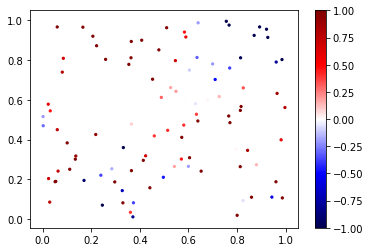

In [3]:
plt.scatter(
    coords[:,0], coords[:,1],
    c=y, s=5,
    vmin=-1, vmax=1, cmap='seismic'
)
plt.colorbar()
plt.show()

We will train an NNGP to model this surface. We specify the model below, using the squared exponential kernel and conditioning the likelihood of each training observation on at most 3 others.

In [4]:
# covModel = pyNNGP.SqExp(
#     sigmaSq=0.5, 
#     phi=5.0, phiUnifa=1.0, phiUnifb=50.0, phiTuning=1.0, 
#     sigmaSqIGa=0.04, sigmaSqIGb=0.04
# )

# noiseModel = pyNNGP.ConstHomogeneousNoiseModel(0.01)

# distFunc = pyNNGP.Euclidean()

# nngp = pyNNGP.SeqNNGP(
#     y, coords,
#     nNeighbors=m,
#     covModel=covModel,
#     distFunc=distFunc,
#     noiseModel=noiseModel
# )

In [5]:
coords.shape

(100, 2)

In [6]:
# w_samples = []
# for i in range(30):
#     nngp.sample(10)
#     w_samples.append(np.copy(nngp.w))

In [7]:
@interact(i=widgets.IntSlider(min=0, max=len(w_samples)-1, value=0))
def f(i):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 3.5))
    i0 = axes[0].scatter(
        coords[:,0], coords[:,1], 
        c=w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i0, ax=axes[0])
    i1 = axes[1].scatter(
        coords[:,0], coords[:,1],
        c=w_samples[i], s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i1, ax=axes[1])
    i2 = axes[2].scatter(
        coords[:,0], coords[:,1],
        c=w_samples[i]-w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )
    plt.colorbar(i2, ax=axes[2])
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=19), Output()), _dom_classes=('widget-interact',…

In [8]:
w_map, Xstar = nngp.MAPPredict(coords.T)

In [9]:
w_map = w_map.reshape((n))

In [10]:
w_map.shape

(100,)

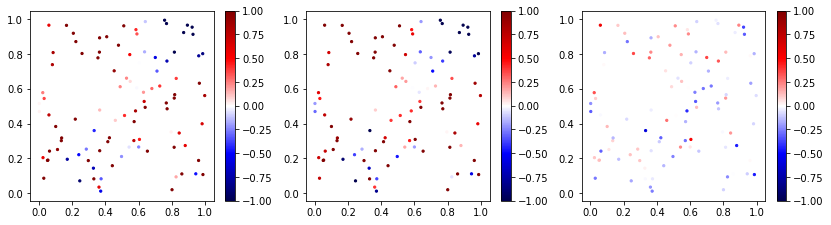

In [11]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 3.5))
i0 = axes[0].scatter(
    coords[:,0], coords[:,1], 
    c=w, s=5,
    vmin=-1, vmax=1, cmap='seismic'
)    
plt.colorbar(i0, ax=axes[0])
i1 = axes[1].scatter(
    coords[:,0], coords[:,1],
    c=w_map, s=5,
    vmin=-1, vmax=1, cmap='seismic'
)    
plt.colorbar(i1, ax=axes[1])
i2 = axes[2].scatter(
    coords[:,0], coords[:,1],
    c=w_map-w, s=5,
    vmin=-1, vmax=1, cmap='seismic'
)
plt.colorbar(i2, ax=axes[2])
plt.show()

Now we will normalize the coordinates to project onto the unit circle.

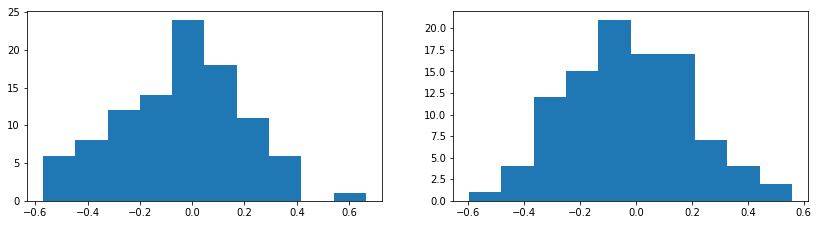

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 3.5))
i0 = axes[0].hist(w_samples[-1] - w)    
i1 = axes[1].hist(w_map - w)
plt.show()